# TP2 - ADVANCES IN MACHINE VISION
Giuseppe Ricciardi, 20235324, 12/01/2024

The goal is to generate realistic segmented images from input images using a GAN, making the task more accessible while still providing valuable experience in image segmentation.
Use a subset of the cityscapes Dataset. The pytorch dataloader is Cityscapes(root[, split, mode, target_type, ...])
Conditional GAN for Image-to-Image Translation:
Implement a conditional GAN (cGAN) architecture for image-to-image translation. The
generator will take an input image, and the discriminator will assess the realism of the generated segmented image compared to the ground truth.

## Training GAN:
Train the cGAN on the paired dataset, optimizing the generator to produce accurate segmented images and the discriminator to distinguish between real and generated pairs.

First we include the libraries

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch.nn as nn
import torch
import torchvision
from glob import glob
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transform
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import numpy as np
import os
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset, DataLoader, random_split, Dataset
from torchvision.io import read_image
from torch.autograd import Variable

Then we prepare the dataset and dataloader. We use the Cityscapes dataset, which is a dataset for semantic segmentation.

The images are composed by two part, the left part is the original image while the right part is the segmented image (the label). <br/>
We will define a class to handle the image.

In [6]:
class MyDataset(Dataset):
    def __init__(self, images_path ,transform_img=None ,transform_label=None):

        self.images_path = images_path
        self.transform_img = transform_img
        self.transform_label = transform_label

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, idx):
        #read the image
        img = plt.imread(self.images_path[idx])
        #split the image into image and label, the label is the right half of the image.
        image,label = img[:,:int(img.shape[1]/2)],img[:,int(img.shape[1]/2):]

        if self.transform_img:
            image = self.transform_img(image)

        if self.transform_label:
            label = self.transform_label(label)

        return image, label

The transformation to apply to the image is the following:

train_dataset length:  2975
val_dataset length:  500
train_loader length:  186
val_loader length:  500


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


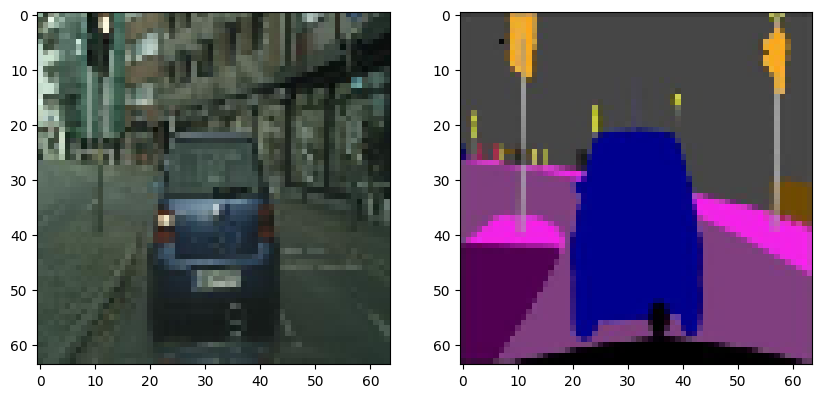

In [7]:
train_path = glob('./drive/MyDrive/Dataset/train/*')
val_path = glob('./drive/MyDrive/Dataset/val/*')
train_dataset = []
val_dataset = []
#transformations to be applied to the images
mytransformsImage = transform.Compose(
    [
        transforms.ToPILImage(),
        transform.ToTensor(),
        transform.Resize((64,64)),
    ]
)
#transformation to be applied to the labels
mytransformsLabel = transform.Compose(
    [
        transforms.ToPILImage(),
        transform.ToTensor(),
        transform.Resize((64,64))
    ]
)
#creating the dataloaders
# train dataset
train_dataset = MyDataset(train_path, mytransformsImage, mytransformsLabel)
# val dataset
val_dataset = MyDataset(val_path, mytransformsImage, mytransformsLabel)
# DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset,batch_size, shuffle = True, pin_memory=True)
val_loader = DataLoader(val_dataset,1)
#printing info about the dataset
print("train_dataset length: ",len(train_dataset))
print("val_dataset length: ",len(val_dataset))
print("train_loader length: ",len(train_loader))
print("val_loader length: ",len(val_loader))
#showing the first image from the training set
img,label = train_dataset[0]
fig,ax = plt.subplots(1,2,figsize=(10,10))
#.permute(1, 2, 0) is used to change the order of the dimensions from (C,H,W) to (H,W,C) required by matplotlib
ax[0].imshow(img.permute(1, 2, 0).numpy())
ax[1].imshow(label.permute(1, 2, 0).numpy())

Let's implement the ***CGAN architecture***, the architecture is similar to the Vanilla GAN but both the generator and discriminator are conditioned on additional information (the label).

In [8]:
nf = 64 # number of generator filters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_size = 64 # size of the image
nc = 3 # number of channels
ngpu = 16 # number of gpus
#Generator class, it takes as input the number of filters, the size of the image and the number of channels
#it returns the generated image, the output has the same size of the input image and the same number of channels

class Generator(nn.Module):
    def __init__(self,nf, img_size, nc):
        super().__init__()
        self.nc = nc
        self.img_size = img_size
        self.nf = nf
        #downsampling layers to reduce the size of the image and increase the number of filters
        self.downSampling = nn.Sequential(
            #convolutional layer with 4x4 kernel, stride 2 and padding 1, the number of filters is equal to the number of generator filters
            nn.Conv2d(nc, self.nf, 4, 2, 1, bias=False),
            #leaky relu activation function with slope 0.2, inplace is set to true to reduce the memory usage
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.nf, self.nf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.nf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.nf * 2, self.nf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.nf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.nf * 4, self.nf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.nf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.nf * 8, self.nf * 16, 4, 1, 0, bias=False),
        )
        #upsampling layers to increase the size of the image and reduce the number of filters
        self.upSampling = nn.Sequential(
            #transpose convolutional layer with 4x4 kernel, stride 1 and padding 0, the number of filters is equal to the number of generator filters
            nn.ConvTranspose2d( self.nf * 16, nf * 16, 4, 1, 0, bias=False),
            #batch normalization layer to normalize the output of the previous layer
            nn.BatchNorm2d(nf * 16),
            #relu activation function with inplace set to true to reduce the memory usage
            nn.ReLU(True),

            nn.ConvTranspose2d(nf * 16, nf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d( nf * 8, nf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d( nf * 4, nf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d( nf*2, nc, 4, 2, 1, bias=False),
            #tanh layer to get the output in the range [-1,1]
            nn.Tanh()
        )

    def forward(self, input):
        x = self.downSampling(input)
        out = self.upSampling(x)
        return out

#Discriminator class, it takes as input the number of filters, the size of the image and the number of channels
#it returns the probability that the input image is real or fake
class Discriminator(nn.Module):
    def __init__(self, ngpu, img_size, nc):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.img_size = img_size
        self.nc = nc

        self.main = nn.Sequential(

            nn.Conv2d(nc*2, nf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nf, nf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nf * 2, nf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nf * 4, nf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()

        )

    def forward(self, x, labels):

        # Concat image & label
        x = torch.cat([x, labels], 1)
        # print(x.shape)
        # Discriminator out
        out = self.main(x)
        # print(out.shape)
        return out.view(-1,1,1,1)

#custom weights initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        #apply normal distribution with mean 0 and standard deviation 0.02 to the weights of the convolutional layers
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        #apply normal distribution with mean 1 and standard deviation 0.02 to the weights of the batch normalization layers
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        #apply 0 to the bias of the batch normalization layers
        nn.init.constant_(m.bias.data, 0)

The training process is describe as follow:
#### Generator Training:

1. Generate synthetic samples using the generator with random noise and conditional information.
2. Compute the generator loss (adversarial loss + conditional loss).
3. Backpropagate the loss through the generator and update its weights.

#### Discriminator Training:

1. Present a batch of real samples with their conditional information and a batch of generated samples with the same conditional information to the discriminator.
2. Compute adversarial loss for real and generated samples.
3. Compute conditional loss based on the conditional information.
4. Update the discriminator's weights.


In [9]:
#visualize images, pass the list of images to be visualized -> [input, output, predicted]
def show(pckt):

    iters = 1
    #if the input is a batch of images with shape (batch_size, channels, height, width) then iters is equal to batch_size
    if len(pckt[0].shape) > 3:
        iters = pckt[0].shape[0]
        #show the images in the batch one by one
        for j in range(iters):
            #create a list of images to be visualized: label, real, predicted
            img = [None]*3
            n = 3
            labels = ['Label', 'Real', 'Predicted']
            fig, ax = plt.subplots(1, n, figsize=(10, 30))
            for i in range(n):
                #convert the tensor to numpy array and transpose the dimensions from (C,H,W) to (H,W,C) required by matplotlib
                x = torch.Tensor.cpu(pckt[j][i])
                x = x.detach().numpy()
                ax[i].imshow(np.transpose(x,(1,2,0)))
                ax[i].set_title(labels[i])
    #if the input is a single image with shape (channels, height, width) then iters is equal to 1
    else:
        img = [None]*3
        #show the images in the list one by one
        n = len(pckt)
        labels = ['Input', 'Output', 'Predicted']
        fig, ax = plt.subplots(1, n, figsize=(10, 30))
        for i in range(n):
            x = torch.Tensor.cpu(pckt[i])
            x = x.detach().numpy()
            ax[i].imshow(np.transpose(x,(1,2,0)))
            ax[i].set_title(labels[i])

Starting Training CGAN
Starting epoch 1
g_loss: 0.7024855017662048, d_loss: 1.5939182043075562


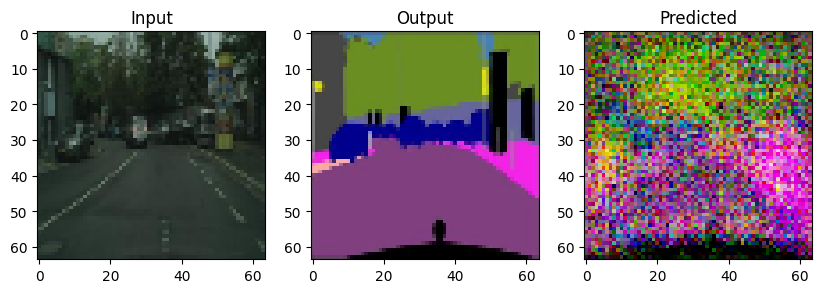

Starting epoch 2
g_loss: 0.553470253944397, d_loss: 1.5511757135391235
Starting epoch 3
g_loss: 0.8254504203796387, d_loss: 1.24810791015625
Starting epoch 4
g_loss: 1.6345945596694946, d_loss: 1.1172475814819336
Starting epoch 5
g_loss: 1.332196831703186, d_loss: 1.270755410194397
Starting epoch 6
g_loss: 0.20173713564872742, d_loss: 2.593190908432007
Starting epoch 7
g_loss: 1.1378469467163086, d_loss: 0.9627701640129089
Starting epoch 8
g_loss: 0.667488157749176, d_loss: 1.5454672574996948
Starting epoch 9
g_loss: 1.2713544368743896, d_loss: 1.2098944187164307
Starting epoch 10
g_loss: 1.1177898645401, d_loss: 1.0292079448699951
Starting epoch 11
g_loss: 1.6668128967285156, d_loss: 1.220938801765442


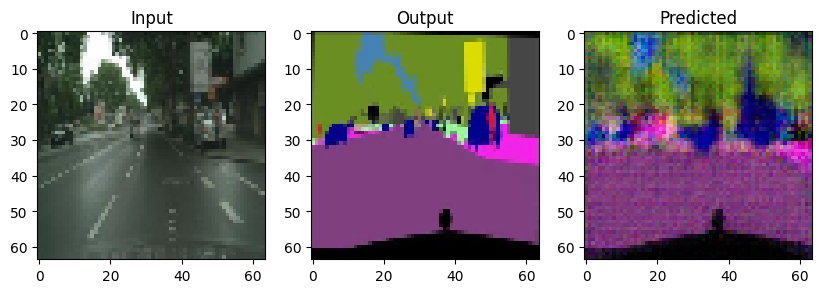

Starting epoch 12
g_loss: 2.8155128955841064, d_loss: 1.1215102672576904
Starting epoch 13
g_loss: 1.2498151063919067, d_loss: 0.8740841150283813
Starting epoch 14
g_loss: 1.2476251125335693, d_loss: 0.9703165292739868
Starting epoch 15
g_loss: 1.0544533729553223, d_loss: 0.7233000993728638
Starting epoch 16
g_loss: 1.3774712085723877, d_loss: 0.7154504060745239
Starting epoch 17
g_loss: 0.9110016226768494, d_loss: 1.3672834634780884
Starting epoch 18
g_loss: 1.9034689664840698, d_loss: 0.6329393982887268
Starting epoch 19
g_loss: 2.9451189041137695, d_loss: 0.5721177458763123
Starting epoch 20
g_loss: 0.8341894745826721, d_loss: 0.7233895063400269
Starting epoch 21
g_loss: 0.7293742299079895, d_loss: 0.8425763845443726


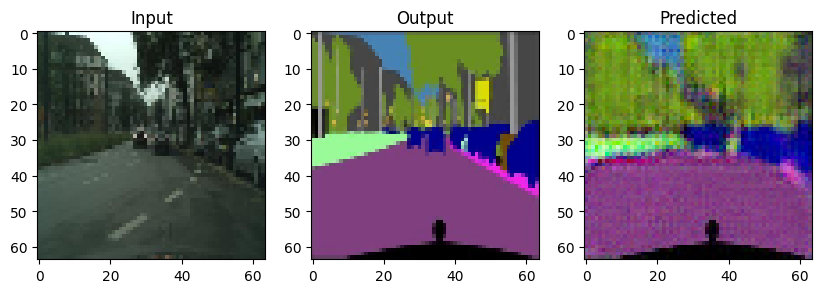

Starting epoch 22
g_loss: 3.9770445823669434, d_loss: 1.4684196710586548
Starting epoch 23
g_loss: 1.4537765979766846, d_loss: 2.2281196117401123
Starting epoch 24
g_loss: 4.112798690795898, d_loss: 0.7995022535324097
Starting epoch 25
g_loss: 1.128836989402771, d_loss: 0.9097416996955872
Starting epoch 26
g_loss: 1.931982159614563, d_loss: 0.6460558176040649
Starting epoch 27
g_loss: 3.2726030349731445, d_loss: 1.3098866939544678
Starting epoch 28
g_loss: 3.674804925918579, d_loss: 0.885997474193573
Starting epoch 29
g_loss: 4.061619281768799, d_loss: 0.826919436454773
Starting epoch 30
g_loss: 1.63181471824646, d_loss: 0.5995564460754395
Starting epoch 31
g_loss: 2.439584493637085, d_loss: 0.7615565657615662


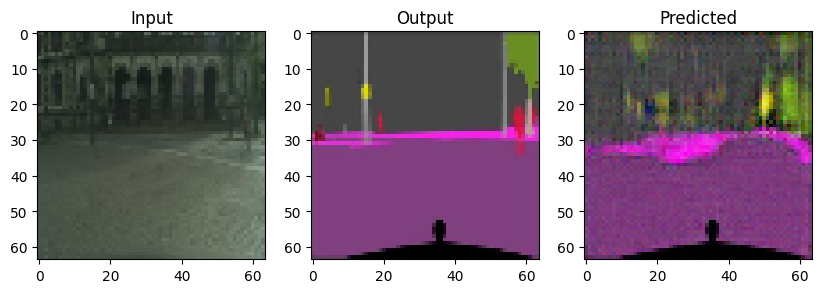

Starting epoch 32
g_loss: 0.9590498208999634, d_loss: 0.7752516269683838
Starting epoch 33
g_loss: 1.8104349374771118, d_loss: 0.7349518537521362
Starting epoch 34
g_loss: 3.451280117034912, d_loss: 0.9291390180587769
Starting epoch 35
g_loss: 0.8955528736114502, d_loss: 1.4256913661956787
Starting epoch 36
g_loss: 4.030901908874512, d_loss: 1.4014596939086914
Starting epoch 37
g_loss: 0.7723469138145447, d_loss: 0.9649783968925476
Starting epoch 38
g_loss: 3.0313785076141357, d_loss: 0.7298973798751831
Starting epoch 39
g_loss: 4.20361328125, d_loss: 1.2639259099960327
Starting epoch 40
g_loss: 4.7405571937561035, d_loss: 1.0171900987625122
Starting epoch 41
g_loss: 0.9386130571365356, d_loss: 0.8350969552993774


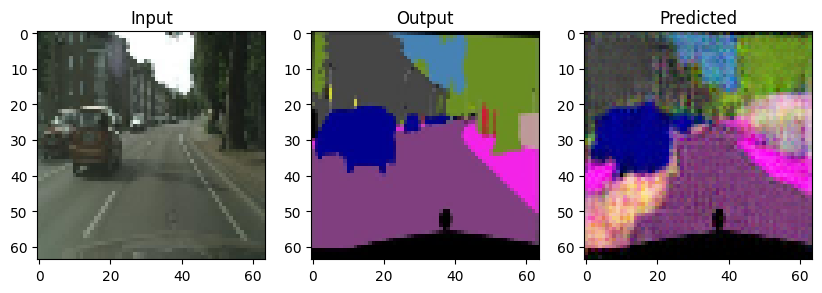

Starting epoch 42
g_loss: 0.9381914138793945, d_loss: 1.0163154602050781
Starting epoch 43
g_loss: 1.7309139966964722, d_loss: 0.6349897384643555
Starting epoch 44
g_loss: 1.6030936241149902, d_loss: 0.9365720748901367
Starting epoch 45
g_loss: 3.3847193717956543, d_loss: 0.8562650084495544
Starting epoch 46
g_loss: 5.936580657958984, d_loss: 1.1715091466903687
Starting epoch 47
g_loss: 3.8082849979400635, d_loss: 0.6877220273017883
Starting epoch 48
g_loss: 1.0097140073776245, d_loss: 0.6702931523323059
Starting epoch 49
g_loss: 0.36541908979415894, d_loss: 2.7450356483459473
Starting epoch 50
g_loss: 0.7141958475112915, d_loss: 0.751795768737793


In [23]:
#Training GAN
print("Starting Training CGAN")
# Setup Adam optimizers for both G and D
discriminator = Discriminator(ngpu, img_size, nc).to(device)
generator =  Generator(nf, img_size, nc).to(device)
d_optimizer = optim.Adam(discriminator.parameters(), lr = 0.0002, betas = (0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr = 0.0002, betas = (0.5, 0.999))
# Initialize BCELoss function
criterion  = nn.BCELoss()
num_epochs = 50
loss_Discriminator = 0

generator.apply(weights_init)
discriminator.apply(weights_init)
for e in range(num_epochs):
    running_loss_D = 0.0
    print('Starting epoch {}'.format(e+1))
    for i, (input,output) in enumerate(train_loader, 0):
    #Update Discriminator
        #Loss on real Images
        discriminator.zero_grad()
        predicted = discriminator(input.to(device),output.to(device))
        loss_real = criterion(predicted, torch.ones((len(predicted)), 1, 1,1, dtype=torch.float, device=device).to(device))
        loss_real.backward(retain_graph=True)
        #Loss on fake Images
        fake_output = generator(input.to(device))
        predicted = discriminator(input.to(device),fake_output.to(device))
        loss_fake = criterion(predicted, torch.zeros((len(predicted)), 1, 1,1, dtype=torch.float, device=device).to(device))
        loss_fake.backward(retain_graph=True)
        loss_Discriminator = loss_real + loss_fake
        d_optimizer.step()

      # Update Generator
        generator.zero_grad()
        predicted = discriminator(input.to(device),fake_output.to(device))
        loss_gen = criterion(predicted, torch.ones((len(predicted)), 1, 1,1, dtype=torch.float, device=device).to(device))
        loss_gen.backward()
        g_optimizer.step()
        running_loss_D +=  loss_Discriminator.item()

    print('g_loss: {}, d_loss: {}'.format(loss_gen, loss_Discriminator))
    if(e%10==0 or e==0):
        # Generate random noise and labels
        data_iter = iter(train_loader)
        input, output = next(data_iter)
        input = input.to(device)
        output = output.to(device)
        # Forward pass through the generator
        generated_image = generator(input).data.cpu().to(device)
        show([input[0], output[0], generated_image[0]])
        plt.show()

In [10]:
#Saving the model
torch.save(generator.state_dict(), './generator.pth')
print("Model saved")

NameError: name 'generator' is not defined

### Evaluation
For evaluate the model we will use the pixel-wise accuracy, that measures the percentage of correctly classified pixels in the segmentation results compared to the ground truth. <br/>
Defined as:
$$ \text{Pixel-wise Accuracy} = \frac{\text{Number of Correctly Classified Pixels}}{\text{Total Number of Pixels}} \times 100\% $$

In [11]:
def pixel_wise_accuracy(prediction, target):
    #Transform the tensors to numpy arrays if they are tensors
    if isinstance(prediction, torch.Tensor):
        prediction = prediction.cpu().numpy()
    if isinstance(target, torch.Tensor):
        target = target.cpu().numpy()
    #Lower and upper bound to consider a pixel correctly predicted
    lower_bound = -7/255
    upper_bound = 7/255
    #Count the number of correctly predicted pixels
    correct_pixels = np.sum((prediction >= target + lower_bound) & (prediction <= target + upper_bound))
    #Count the total number of pixels
    total_pixels = np.prod(prediction.shape)
    #Return the accuracy
    return correct_pixels / total_pixels




In [ ]:
#Calulate the accuracies on validation set
accuracies = []
count_data = []
for i, (input,output) in enumerate(val_loader, 0):
  input = input.to(device)
  output = output.to(device)
  #Forward pass through the generator
  generated_image = generator(input).data.cpu().to(device)
  #Compute Pixel Accuracy
  accuracy = pixel_wise_accuracy(generated_image, output)
  accuracies.append(accuracy)
  count_data.append(len(input))
total_accuracy = 0
for i in range(len(accuracies)):
  total_accuracy += accuracies[i]*count_data[i]
total_accuracy = total_accuracy/np.sum(count_data)
print(f"Pixel-wise Accuracy on val set: {total_accuracy * 100:.2f}%")

### Comparison
To compare the result, first we define another model for the comparison. The model proposed in this section is the U-Net. <br/>
The architecture is characterized by a U-shaped structure, featuring a contracting path to capture context and a symmetric expanding path for precise localization. The contracting path consists of repeated convolutional and pooling layers to gradually reduce spatial dimensions, while the expanding path employs transposed convolutions to upsample the feature maps. Skip connections between corresponding layers in the contracting and expanding paths help in preserving fine-grained details.

In [24]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size = 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size = 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU(inplace = True)

    def forward(self, x):
#         print(x.shape)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d(2,2)

    def forward(self, x):
        x = self.conv(x) #for skip connection feature map to decoder
        p = self.pool(x)
        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.convT =  nn.ConvTranspose2d(in_c, out_c, kernel_size = 2, padding = 0, stride = 2)
        self.conv = conv_block(2*out_c, out_c)

    def forward(self, inputs, skips):
        x = self.convT(inputs)
        x = torch.cat([x, skips], axis = 1)
        x = self.conv(x)
        return x


class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        """"Encoder part"""

        self.en1 = encoder_block(3, 64)
        self.en2 = encoder_block(64, 128)
        self.en3 = encoder_block(128, 256)
        self.en4 = encoder_block(256, 512)

        """Bottleneck"""

        self.b = conv_block(512, 1024)


        """decoder part"""

        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)


        """Classifier"""
        self.outputs = nn.Conv2d(64, 3, kernel_size=1, padding=0)

    def forward(self, input):
#         print(input.shape)
        s1, p1 = self.en1(input)
        s2, p2 = self.en2(p1)
        s3, p3 = self.en3(p2)
        s4, p4 = self.en4(p3)

        b = self.b(p4)

        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        out = self.outputs(d4)

        return out


During the training process, input images along with their corresponding ground truth segmentation masks are fed into the network. The network learns to map input images to output segmentation masks by adjusting its weights through backpropagation. U-Net's distinctive skip connections facilitate the exchange of information between the contracting and expanding paths, aiding in the preservation of spatial details during training.



100%|██████████| 186/186 [12:11<00:00,  3.93s/it]


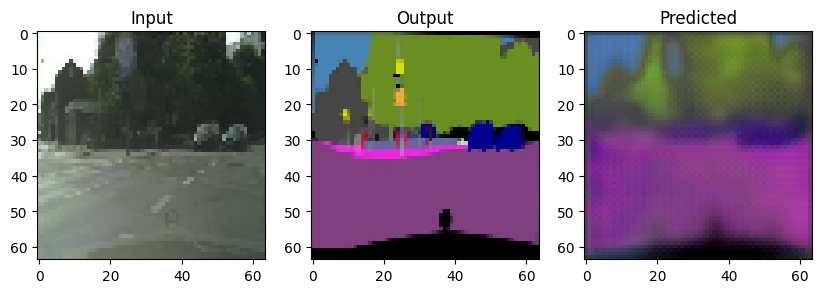

100%|██████████| 500/500 [02:06<00:00,  3.94it/s]


epoch : 0 ,train loss : 0.037379285260554285, valid loss : 0.026193655570968987 


100%|██████████| 500/500 [00:09<00:00, 52.21it/s]


epoch : 1 ,train loss : 0.021853978685553995, valid loss : 0.024227878460660577 


100%|██████████| 500/500 [00:09<00:00, 51.90it/s]


epoch : 2 ,train loss : 0.020160988859471776, valid loss : 0.02359239807166159 


100%|██████████| 500/500 [00:08<00:00, 55.69it/s]


epoch : 3 ,train loss : 0.018928052532056008, valid loss : 0.023052681474015117 


100%|██████████| 500/500 [00:08<00:00, 56.90it/s]


epoch : 4 ,train loss : 0.018103063116551087, valid loss : 0.022921689422801136 


100%|██████████| 500/500 [00:09<00:00, 50.77it/s]


epoch : 5 ,train loss : 0.017696110762014824, valid loss : 0.021509280744940042 


100%|██████████| 500/500 [00:09<00:00, 50.98it/s]


epoch : 6 ,train loss : 0.017060288448407446, valid loss : 0.02174611122906208 


100%|██████████| 500/500 [00:09<00:00, 54.11it/s]


epoch : 7 ,train loss : 0.016103270118154826, valid loss : 0.021742206288501622 


100%|██████████| 500/500 [00:08<00:00, 58.93it/s]


epoch : 8 ,train loss : 0.01558491018831089, valid loss : 0.019106396426446737 


100%|██████████| 500/500 [00:09<00:00, 52.50it/s]


epoch : 9 ,train loss : 0.015189869319319083, valid loss : 0.0202057403344661 


100%|██████████| 186/186 [00:46<00:00,  4.03it/s]


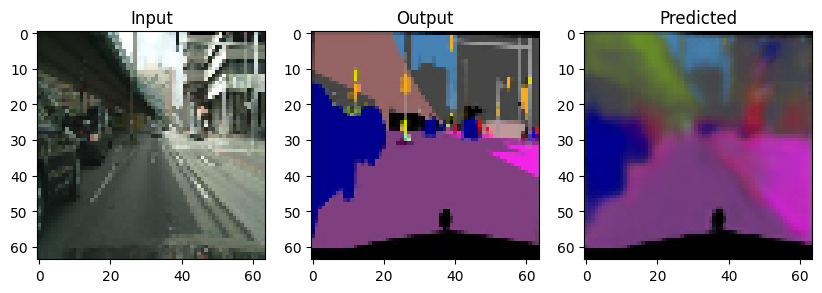

100%|██████████| 500/500 [00:09<00:00, 52.41it/s]


epoch : 10 ,train loss : 0.014434296667816178, valid loss : 0.018961794840171933 


100%|██████████| 500/500 [00:08<00:00, 58.77it/s]


epoch : 11 ,train loss : 0.014223759493199728, valid loss : 0.019358533867634833 


100%|██████████| 500/500 [00:09<00:00, 55.02it/s]


epoch : 12 ,train loss : 0.014000041044807883, valid loss : 0.018448006588034332 


100%|██████████| 500/500 [00:09<00:00, 50.52it/s]


epoch : 13 ,train loss : 0.013649706728756428, valid loss : 0.01876001115143299 


100%|██████████| 500/500 [00:09<00:00, 52.27it/s]


epoch : 14 ,train loss : 0.013275465857918544, valid loss : 0.017834579983726145 


100%|██████████| 500/500 [00:08<00:00, 58.74it/s]


epoch : 15 ,train loss : 0.013078076434471914, valid loss : 0.017693779935128988 


100%|██████████| 500/500 [00:08<00:00, 56.23it/s]


epoch : 16 ,train loss : 0.012761914732074865, valid loss : 0.017711389764212073 


100%|██████████| 500/500 [00:09<00:00, 51.97it/s]


epoch : 17 ,train loss : 0.012404200766155477, valid loss : 0.017258186438120902 


100%|██████████| 500/500 [00:09<00:00, 52.16it/s]


epoch : 18 ,train loss : 0.012321250628359535, valid loss : 0.01736594185139984 


100%|██████████| 500/500 [00:08<00:00, 58.10it/s]


epoch : 19 ,train loss : 0.012145834949909038, valid loss : 0.01801519883237779 


100%|██████████| 186/186 [00:47<00:00,  3.94it/s]


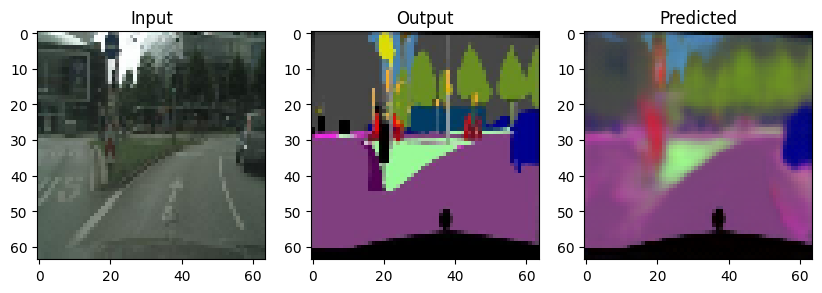

100%|██████████| 500/500 [00:08<00:00, 55.56it/s]


epoch : 20 ,train loss : 0.011964621773410228, valid loss : 0.01678883048892021 


100%|██████████| 500/500 [00:09<00:00, 50.94it/s]


epoch : 21 ,train loss : 0.0117209479713472, valid loss : 0.016718834914267063 


100%|██████████| 500/500 [00:10<00:00, 49.90it/s]


epoch : 22 ,train loss : 0.011537995149371445, valid loss : 0.016497973413206638 


100%|██████████| 500/500 [00:09<00:00, 52.91it/s]


epoch : 23 ,train loss : 0.01124587208433177, valid loss : 0.01692819715756923 


100%|██████████| 500/500 [00:08<00:00, 57.06it/s]


epoch : 24 ,train loss : 0.011074066071981383, valid loss : 0.017050651771947742 


100%|██████████| 500/500 [00:09<00:00, 53.25it/s]


epoch : 25 ,train loss : 0.011019074973920661, valid loss : 0.01789340720605105 


100%|██████████| 500/500 [00:09<00:00, 51.13it/s]


epoch : 26 ,train loss : 0.010733415898416311, valid loss : 0.015953741431236266 


100%|██████████| 500/500 [00:09<00:00, 51.38it/s]


epoch : 27 ,train loss : 0.010711108432001164, valid loss : 0.016798477245494724 


100%|██████████| 500/500 [00:08<00:00, 60.93it/s]


epoch : 28 ,train loss : 0.010376124137071192, valid loss : 0.01631130859721452 


100%|██████████| 500/500 [00:09<00:00, 51.66it/s]


epoch : 29 ,train loss : 0.010291112867254083, valid loss : 0.01699109941255301 


100%|██████████| 186/186 [00:46<00:00,  3.98it/s]


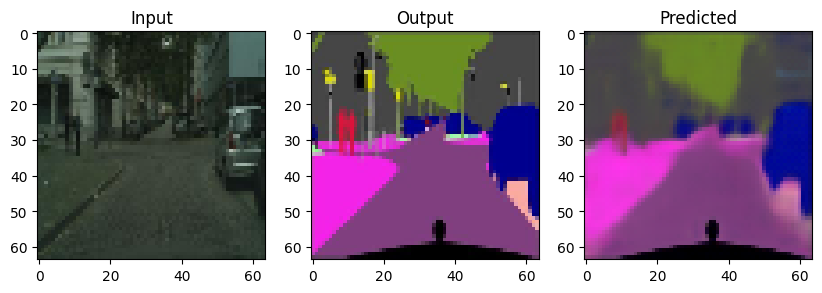

100%|██████████| 500/500 [00:10<00:00, 48.13it/s]


epoch : 30 ,train loss : 0.010246790284591337, valid loss : 0.016682851795107125 


100%|██████████| 500/500 [00:09<00:00, 53.67it/s]


epoch : 31 ,train loss : 0.010022842470476384, valid loss : 0.015995995988138022 


100%|██████████| 500/500 [00:08<00:00, 60.68it/s]


epoch : 32 ,train loss : 0.009671653373046749, valid loss : 0.01616802198346704 


100%|██████████| 500/500 [00:09<00:00, 55.13it/s]


epoch : 33 ,train loss : 0.009533582405457574, valid loss : 0.016457525971345602 


100%|██████████| 500/500 [00:09<00:00, 52.45it/s]


epoch : 34 ,train loss : 0.00947096061101684, valid loss : 0.01658764478005469 


100%|██████████| 500/500 [00:08<00:00, 58.07it/s]


epoch : 35 ,train loss : 0.009270799018302432, valid loss : 0.016623202414251866 


100%|██████████| 500/500 [00:08<00:00, 56.15it/s]


epoch : 36 ,train loss : 0.009076453592648269, valid loss : 0.01566500409692526 


100%|██████████| 500/500 [00:09<00:00, 53.04it/s]


epoch : 37 ,train loss : 0.008815852088993915, valid loss : 0.015817593364976346 


100%|██████████| 500/500 [00:08<00:00, 56.37it/s]


epoch : 38 ,train loss : 0.008599586889988953, valid loss : 0.016221808224916458 


100%|██████████| 500/500 [00:08<00:00, 57.02it/s]


epoch : 39 ,train loss : 0.008445189204267275, valid loss : 0.015667930129915474 


100%|██████████| 186/186 [00:45<00:00,  4.07it/s]


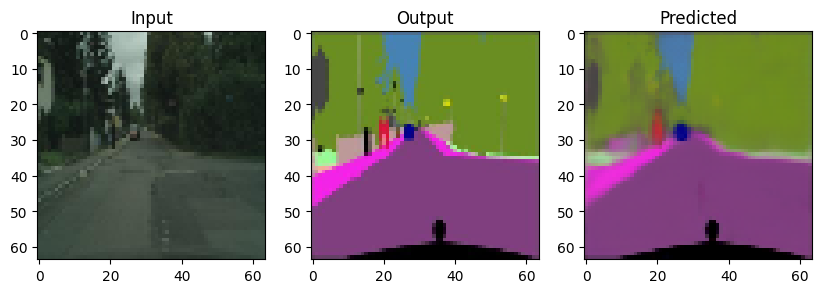

100%|██████████| 500/500 [00:09<00:00, 51.84it/s]


epoch : 40 ,train loss : 0.008409092728529246, valid loss : 0.015350371716544032 


100%|██████████| 500/500 [00:09<00:00, 52.39it/s]


epoch : 41 ,train loss : 0.008229194837371988, valid loss : 0.015828664754517375 


100%|██████████| 500/500 [00:08<00:00, 58.23it/s]


epoch : 42 ,train loss : 0.008058823134389615, valid loss : 0.01562662829644978 


100%|██████████| 500/500 [00:09<00:00, 53.61it/s]


epoch : 43 ,train loss : 0.007974104465095586, valid loss : 0.01587959399446845 


100%|██████████| 500/500 [00:10<00:00, 49.86it/s]


epoch : 44 ,train loss : 0.00787665564767135, valid loss : 0.015618113511241972 


100%|██████████| 500/500 [00:09<00:00, 53.88it/s]


epoch : 45 ,train loss : 0.0076526424081455316, valid loss : 0.01580216278415173 


100%|██████████| 500/500 [00:08<00:00, 59.43it/s]


epoch : 46 ,train loss : 0.007377001221582133, valid loss : 0.015389697948470712 


100%|██████████| 500/500 [00:09<00:00, 54.02it/s]


epoch : 47 ,train loss : 0.0073531918122523255, valid loss : 0.015974104214459658 


100%|██████████| 500/500 [00:09<00:00, 54.23it/s]


epoch : 48 ,train loss : 0.007292338606891453, valid loss : 0.015557084852829575 


100%|██████████| 500/500 [00:08<00:00, 60.71it/s]

epoch : 49 ,train loss : 0.007087495751298403, valid loss : 0.01570257101394236 


In [25]:
#Training
unet = Unet().float().to(device)
lossfunc = nn.MSELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=0.01)
train_acc = []
val_acc = []
train_loss = []
val_loss = []

for i in range(50):
    trainloss = 0
    valloss = 0
    for img,label in tqdm(train_loader):
        optimizer.zero_grad()
        img = img.to(device)
        label = label.to(device)
        output = unet(img)
        loss = lossfunc(output,label)
        loss.backward()
        optimizer.step()
        trainloss+=loss.item()

    if(i%10==0 or i==0):
        show((img[0],label[0], output[0]))
        plt.show()

    train_loss.append(trainloss/len(train_loader))

    for img,label in tqdm(val_loader):
        img = img.to(device)
        label = label.to(device)
        output = unet(img)
        loss = lossfunc(output,label)
        valloss+=loss.item()

    val_loss.append(valloss/len(val_loader))

    print("epoch : {} ,train loss : {}, valid loss : {} ".format(i,train_loss[-1],val_loss[-1]))

Let's see the Pixel-wise Accuracy of the UNet to make the comparison

In [26]:
accuracies = []
count_data = []
for i, (input,output) in enumerate(val_loader, 0):
  input = input.to(device)
  output = output.to(device)
  #Forward pass through the generator
  generated_image = unet(input).data.cpu().to(device)

  #Compute Pixel Accuracy
  accuracy = pixel_wise_accuracy(generated_image, output)
  accuracies.append(accuracy)
  count_data.append(len(input))
total_accuracy = 0
for i in range(len(accuracies)):
  total_accuracy += accuracies[i]*count_data[i]
total_accuracy = total_accuracy/np.sum(count_data)
print(f"Pixel-wise Accuracy on val set: {total_accuracy * 100:.2f}%")

Pixel-wise Accuracy on val set: 55.50%


As we can see the Unet overperform the CGAN, but the CGAN results still be quite recognisable